In [1]:
import dagshub
dagshub.init(repo_owner='Shubhamraut97', repo_name='experemntracking', mlflow=True)

Accessing as Shubhamraut97

Initialized MLflow to track repo "Shubhamraut97/experemntracking"

Repository Shubhamraut97/experemntracking initialized!

In [2]:
import mlflow
import mlflow.sklearn


In [3]:
mlflow.set_tracking_uri("https://dagshub.com/Shubhamraut97/experemntracking.mlflow")

In [4]:
import optuna
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN
import plotly.express as px



/Users/shubham/Desktop/sentimentanalysis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mlflow.set_experiment("light gbm hp")

<Experiment: artifact_location='mlflow-artifacts:/4f5cd9e07f284268bef2951bbfeeab51', creation_time=1753706984087, experiment_id='7', last_update_time=1753706984087, lifecycle_stage='active', name='light gbm hp', tags={}>

In [6]:
df= pd.read_csv('processed_data.csv').dropna(subset=['clean_comment'])
df.shape

(36661, 2)

In [7]:
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})


In [8]:
df=df.dropna(subset=['category'])

In [9]:


# === Configuration ===
n_grams = (1, 3)
max_features = 10000
random_state = 42

# === Data Preparation ===
X_raw = df['clean_comment']
y = df['category']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=random_state, stratify=y
)

vectorizer = TfidfVectorizer(ngram_range=n_grams, max_features=max_features)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

adasyn = ADASYN(random_state=random_state)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# === MLflow Logging Function ===
def log_mlflow(model_name, model, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("n_grams", n_grams)
        mlflow.log_param("max_features", max_features)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", acc)

        report = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_name, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric_name}", value)

# === Optuna Objective ===
def objective_lightgbm(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 300),
        max_depth=trial.suggest_int("max_depth", 5, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        class_weight=trial.suggest_categorical("class_weight", [None, "balanced"]),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1.0),
        random_state=random_state
    )
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# === Optuna Runner ===
def run_optuna_lightgbm():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lightgbm, n_trials=70)

    best_params = study.best_params
    best_model = LGBMClassifier(**best_params, random_state=random_state)
    best_model.fit(X_train_resampled, y_train_resampled)

    # Log to MLflow
    log_mlflow("LightGBM_ADASYN", best_model, X_train_resampled, y_train_resampled, X_test, y_test)

    return best_model

# === RUN and Predict ===
final_model = run_optuna_lightgbm()
y_pred = final_model.predict(X_test)

# === Evaluate ===
print("✅ Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))


[I 2025-07-28 21:56:51,980] A new study created in memory with name: no-name-2ffb0605-c019-43a4-94e9-c357752ebf1c


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:57:03,310] Trial 0 finished with value: 0.8693576980771853 and parameters: {'n_estimators': 141, 'max_depth': 20, 'learning_rate': 0.29399648777716, 'class_weight': 'balanced', 'subsample': 0.7140410837472962, 'colsample_bytree': 0.6098764901929749, 'reg_alpha': 0.6765394902624139, 'reg_lambda': 0.975579480901693}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.477940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 21:57:11,833] Trial 1 finished with value: 0.8588572207827628 and parameters: {'n_estimators': 120, 'max_depth': 14, 'learning_rate': 0.26946260106961284, 'class_weight': 'balanced', 'subsample': 0.6558206370524164, 'colsample_bytree': 0.9637859258094228, 'reg_alpha': 0.4419479658323562, 'reg_lambda': 0.7862087909830532}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.375029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:57:19,054] Trial 2 finished with value: 0.8456293467884903 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learning_rate': 0.22587747304031078, 'class_weight': None, 'subsample': 0.9926187202786394, 'colsample_bytree': 0.7174620296668648, 'reg_alpha': 0.35678867132109127, 'reg_lambda': 0.8918484778218296}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:57:30,165] Trial 3 finished with value: 0.8562661939179054 and parameters: {'n_estimators': 162, 'max_depth': 18, 'learning_rate': 0.14785744894887276, 'class_weight': None, 'subsample': 0.9787308445812644, 'colsample_bytree': 0.7222572872719042, 'reg_alpha': 0.5581564802776173, 'reg_lambda': 0.7489089043367838}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:57:40,370] Trial 4 finished with value: 0.8129005863902905 and parameters: {'n_estimators': 257, 'max_depth': 6, 'learning_rate': 0.11178887634789947, 'class_weight': 'balanced', 'subsample': 0.6404211306395874, 'colsample_bytree': 0.9701064086003314, 'reg_alpha': 0.988636535998023, 'reg_lambda': 0.6855240937419709}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.572643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:57:47,481] Trial 5 finished with value: 0.816582571935088 and parameters: {'n_estimators': 118, 'max_depth': 11, 'learning_rate': 0.12779086958489785, 'class_weight': None, 'subsample': 0.6768163221153374, 'colsample_bytree': 0.7900116474006862, 'reg_alpha': 0.6076761631106575, 'reg_lambda': 0.29342906319283935}. Best is trial 0 with value: 0.8693576980771853.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.377114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:58:06,216] Trial 6 finished with value: 0.8719487249420428 and parameters: {'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.2863463131186774, 'class_weight': 'balanced', 'subsample': 0.7410856493567202, 'colsample_bytree': 0.7745700713777377, 'reg_alpha': 0.4350702495902047, 'reg_lambda': 0.9735714840302727}. Best is trial 6 with value: 0.8719487249420428.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.579518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 21:58:26,473] Trial 7 finished with value: 0.8739942724669303 and parameters: {'n_estimators': 246, 'max_depth': 19, 'learning_rate': 0.22472683162471033, 'class_weight': None, 'subsample': 0.8719476780752692, 'colsample_bytree': 0.6589446356417513, 'reg_alpha': 0.8293741251664574, 'reg_lambda': 0.713619559846798}. Best is trial 7 with value: 0.8739942724669303.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.708360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:58:48,700] Trial 8 finished with value: 0.8071730533206055 and parameters: {'n_estimators': 248, 'max_depth': 20, 'learning_rate': 0.030469475433960946, 'class_weight': 'balanced', 'subsample': 0.8595051168565726, 'colsample_bytree': 0.7799714743182438, 'reg_alpha': 0.6038519656960577, 'reg_lambda': 0.3081021523226716}. Best is trial 7 with value: 0.8739942724669303.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.610193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:59:01,390] Trial 9 finished with value: 0.8467203054684304 and parameters: {'n_estimators': 127, 'max_depth': 19, 'learning_rate': 0.14556567340700008, 'class_weight': 'balanced', 'subsample': 0.8045149221485441, 'colsample_bytree': 0.8324984102820787, 'reg_alpha': 0.9132254170098679, 'reg_lambda': 0.06207414011625734}. Best is trial 7 with value: 0.8739942724669303.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.627146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:59:22,378] Trial 10 finished with value: 0.8709941360970953 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.21206699350187577, 'class_weight': None, 'subsample': 0.9076321907847399, 'colsample_bytree': 0.6005448330817416, 'reg_alpha': 0.08078189307461048, 'reg_lambda': 0.5142385829871433}. Best is trial 7 with value: 0.8739942724669303.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.117782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 21:59:48,871] Trial 11 finished with value: 0.8741306423019228 and parameters: {'n_estimators': 292, 'max_depth': 16, 'learning_rate': 0.2223691652994829, 'class_weight': None, 'subsample': 0.7567641829342359, 'colsample_bytree': 0.6887125893106943, 'reg_alpha': 0.30741414251604854, 'reg_lambda': 0.5795662771906126}. Best is trial 11 with value: 0.8741306423019228.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.958817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:00:15,478] Trial 12 finished with value: 0.8719487249420428 and parameters: {'n_estimators': 291, 'max_depth': 17, 'learning_rate': 0.2150912589785368, 'class_weight': None, 'subsample': 0.7959862210744567, 'colsample_bytree': 0.6688472199351756, 'reg_alpha': 0.17131531233580422, 'reg_lambda': 0.5498409662975059}. Best is trial 11 with value: 0.8741306423019228.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.610898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:00:33,322] Trial 13 finished with value: 0.8670394108823128 and parameters: {'n_estimators': 298, 'max_depth': 11, 'learning_rate': 0.1950202557370057, 'class_weight': None, 'subsample': 0.8985290717221412, 'colsample_bytree': 0.6712458872923424, 'reg_alpha': 0.8169285454162615, 'reg_lambda': 0.6183997247944444}. Best is trial 11 with value: 0.8741306423019228.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.638192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:00:54,176] Trial 14 finished with value: 0.8744033819719078 and parameters: {'n_estimators': 215, 'max_depth': 16, 'learning_rate': 0.24216749986490554, 'class_weight': None, 'subsample': 0.7875594971792177, 'colsample_bytree': 0.8668939205258515, 'reg_alpha': 0.2540906967181315, 'reg_lambda': 0.34057462635907726}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.084879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:01:17,780] Trial 15 finished with value: 0.8742670121369153 and parameters: {'n_estimators': 202, 'max_depth': 16, 'learning_rate': 0.24796481684163152, 'class_weight': None, 'subsample': 0.7737409574736184, 'colsample_bytree': 0.8763539875313958, 'reg_alpha': 0.2510980687953024, 'reg_lambda': 0.34769878853732494}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.599595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:01:32,771] Trial 16 finished with value: 0.8705850265921178 and parameters: {'n_estimators': 204, 'max_depth': 13, 'learning_rate': 0.25764532304153176, 'class_weight': None, 'subsample': 0.8317833375173321, 'colsample_bytree': 0.9074780290501644, 'reg_alpha': 0.20951276038938396, 'reg_lambda': 0.372809686520468}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.573535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:01:48,640] Trial 17 finished with value: 0.8630846856675304 and parameters: {'n_estimators': 198, 'max_depth': 11, 'learning_rate': 0.18345838074161375, 'class_weight': None, 'subsample': 0.7697349564446438, 'colsample_bytree': 0.8649680783878353, 'reg_alpha': 0.08708470797785794, 'reg_lambda': 0.1452722518120071}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.683160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:02:01,042] Trial 18 finished with value: 0.808127642165553 and parameters: {'n_estimators': 166, 'max_depth': 9, 'learning_rate': 0.08590963538855366, 'class_weight': None, 'subsample': 0.6067518800357037, 'colsample_bytree': 0.9093677823473225, 'reg_alpha': 0.011480062193246265, 'reg_lambda': 0.41020213457676113}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.239513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:02:21,008] Trial 19 finished with value: 0.8735851629619528 and parameters: {'n_estimators': 213, 'max_depth': 16, 'learning_rate': 0.26020445493143474, 'class_weight': None, 'subsample': 0.7088241183898931, 'colsample_bytree': 0.8901922108370973, 'reg_alpha': 0.25944628967504235, 'reg_lambda': 0.20725252498141955}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.638640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:02:40,017] Trial 20 finished with value: 0.8625392063275603 and parameters: {'n_estimators': 177, 'max_depth': 14, 'learning_rate': 0.1814623475220748, 'class_weight': None, 'subsample': 0.9388510077850021, 'colsample_bytree': 0.8379467526387108, 'reg_alpha': 0.36806437614170473, 'reg_lambda': 0.40511316833513544}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.759818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:02:58,743] Trial 21 finished with value: 0.8741306423019228 and parameters: {'n_estimators': 224, 'max_depth': 16, 'learning_rate': 0.24639783236114968, 'class_weight': None, 'subsample': 0.7616640148701781, 'colsample_bytree': 0.8306724756704352, 'reg_alpha': 0.30532624658199964, 'reg_lambda': 0.4596412409441586}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.583893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:03:23,394] Trial 22 finished with value: 0.8723578344470203 and parameters: {'n_estimators': 276, 'max_depth': 17, 'learning_rate': 0.23906854748528336, 'class_weight': None, 'subsample': 0.8103272103957135, 'colsample_bytree': 0.9323224891257282, 'reg_alpha': 0.16185544079345757, 'reg_lambda': 0.25228107101997416}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.032241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:03:41,500] Trial 23 finished with value: 0.8641756443474703 and parameters: {'n_estimators': 183, 'max_depth': 15, 'learning_rate': 0.17770414790524575, 'class_weight': None, 'subsample': 0.7231773778656794, 'colsample_bytree': 0.720411826185666, 'reg_alpha': 0.2833936952156743, 'reg_lambda': 0.6048515864570667}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.683974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:04:05,101] Trial 24 finished with value: 0.8734487931269603 and parameters: {'n_estimators': 228, 'max_depth': 17, 'learning_rate': 0.27648948994231454, 'class_weight': None, 'subsample': 0.7716539944617963, 'colsample_bytree': 0.8740705697536194, 'reg_alpha': 0.4372446205583128, 'reg_lambda': 0.1433789394570371}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.961079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:04:13,486] Trial 25 finished with value: 0.8426292104186553 and parameters: {'n_estimators': 103, 'max_depth': 13, 'learning_rate': 0.20333564181869224, 'class_weight': None, 'subsample': 0.6859288883979763, 'colsample_bytree': 0.7457934942851951, 'reg_alpha': 0.3548348300277214, 'reg_lambda': 0.3441378927666004}. Best is trial 14 with value: 0.8744033819719078.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.613396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:04:36,470] Trial 26 finished with value: 0.8746761216418928 and parameters: {'n_estimators': 275, 'max_depth': 15, 'learning_rate': 0.24435801694248674, 'class_weight': None, 'subsample': 0.8286152705449368, 'colsample_bytree': 0.9951143834812558, 'reg_alpha': 0.23528766288015446, 'reg_lambda': 0.4489947403767347}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.638015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:04:47,315] Trial 27 finished with value: 0.8626755761625529 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.24282426964908804, 'class_weight': None, 'subsample': 0.8312381047978802, 'colsample_bytree': 0.9899871494087108, 'reg_alpha': 0.10632380311657166, 'reg_lambda': 0.45783461285140903}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.581679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:05:07,000] Trial 28 finished with value: 0.7423973816991681 and parameters: {'n_estimators': 276, 'max_depth': 8, 'learning_rate': 0.019123125093040316, 'class_weight': None, 'subsample': 0.8482676342573966, 'colsample_bytree': 0.9459515530180875, 'reg_alpha': 0.19732674640285836, 'reg_lambda': 0.22467147600156567}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.748504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:05:22,770] Trial 29 finished with value: 0.8735851629619528 and parameters: {'n_estimators': 185, 'max_depth': 15, 'learning_rate': 0.2998070831641698, 'class_weight': 'balanced', 'subsample': 0.7954297762525576, 'colsample_bytree': 0.8527571317159403, 'reg_alpha': 0.5003694549635236, 'reg_lambda': 0.05513484340064817}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:05:44,826] Trial 30 finished with value: 0.8318559934542479 and parameters: {'n_estimators': 223, 'max_depth': 18, 'learning_rate': 0.058659784644776725, 'class_weight': None, 'subsample': 0.8941405084306817, 'colsample_bytree': 0.9945657263659777, 'reg_alpha': 0.010491233844034747, 'reg_lambda': 0.47133046251807276}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.618874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:06:05,893] Trial 31 finished with value: 0.8737215327969453 and parameters: {'n_estimators': 287, 'max_depth': 16, 'learning_rate': 0.2348366596007138, 'class_weight': None, 'subsample': 0.7494711802913667, 'colsample_bytree': 0.8089983269500617, 'reg_alpha': 0.2670752091109776, 'reg_lambda': 0.5636097964765354}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.809935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:06:25,003] Trial 32 finished with value: 0.8719487249420428 and parameters: {'n_estimators': 261, 'max_depth': 14, 'learning_rate': 0.26204734519186357, 'class_weight': None, 'subsample': 0.7245180743913885, 'colsample_bytree': 0.9282893333621144, 'reg_alpha': 0.22977052840762738, 'reg_lambda': 0.6354900688501504}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.869986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:06:44,280] Trial 33 finished with value: 0.8709941360970953 and parameters: {'n_estimators': 284, 'max_depth': 15, 'learning_rate': 0.27923932448223887, 'class_weight': None, 'subsample': 0.784958854501997, 'colsample_bytree': 0.642666537102406, 'reg_alpha': 0.346144519950811, 'reg_lambda': 0.33271967540905084}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.649456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:07:05,017] Trial 34 finished with value: 0.8704486567571253 and parameters: {'n_estimators': 240, 'max_depth': 18, 'learning_rate': 0.16415254184123615, 'class_weight': None, 'subsample': 0.825283186591653, 'colsample_bytree': 0.7603849137328738, 'reg_alpha': 0.15291043686587766, 'reg_lambda': 0.821981605278161}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.668698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:07:25,040] Trial 35 finished with value: 0.8711305059320879 and parameters: {'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.22220653740824825, 'class_weight': 'balanced', 'subsample': 0.6958371756645079, 'colsample_bytree': 0.6981517931801733, 'reg_alpha': 0.40676584048448505, 'reg_lambda': 0.40431432963071057}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.679069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:07:47,994] Trial 36 finished with value: 0.8729033137869903 and parameters: {'n_estimators': 257, 'max_depth': 17, 'learning_rate': 0.2523577651106126, 'class_weight': None, 'subsample': 0.7440600419095744, 'colsample_bytree': 0.8947494153564867, 'reg_alpha': 0.5086335309868861, 'reg_lambda': 0.51646944437354}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.631627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:08:08,838] Trial 37 finished with value: 0.8684031092322378 and parameters: {'n_estimators': 210, 'max_depth': 16, 'learning_rate': 0.19975786516011368, 'class_weight': None, 'subsample': 0.77315818446506, 'colsample_bytree': 0.810088412636165, 'reg_alpha': 0.3095598019964226, 'reg_lambda': 0.26396091590133264}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.423216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:08:21,716] Trial 38 finished with value: 0.8730396836219828 and parameters: {'n_estimators': 235, 'max_depth': 12, 'learning_rate': 0.2879673727061976, 'class_weight': 'balanced', 'subsample': 0.669394340976334, 'colsample_bytree': 0.9652957885955045, 'reg_alpha': 0.13159130335900107, 'reg_lambda': 0.6687369016772601}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.581841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:08:29,679] Trial 39 finished with value: 0.8576298922678304 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.27252360452214186, 'class_weight': None, 'subsample': 0.877948769171916, 'colsample_bytree': 0.6372433877959854, 'reg_alpha': 0.39070389552424656, 'reg_lambda': 0.7825172417417292}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.449423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:08:49,041] Trial 40 finished with value: 0.8720850947770353 and parameters: {'n_estimators': 249, 'max_depth': 19, 'learning_rate': 0.23348986734137675, 'class_weight': None, 'subsample': 0.8165995571429947, 'colsample_bytree': 0.6980526424750988, 'reg_alpha': 0.7322162999737332, 'reg_lambda': 0.4543082336016695}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.522089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:09:05,192] Trial 41 finished with value: 0.8738579026319379 and parameters: {'n_estimators': 222, 'max_depth': 16, 'learning_rate': 0.24418253465707773, 'class_weight': None, 'subsample': 0.7404738801789618, 'colsample_bytree': 0.8279749985536179, 'reg_alpha': 0.31972375513925294, 'reg_lambda': 0.43418296993002936}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.680455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:09:22,303] Trial 42 finished with value: 0.8718123551070504 and parameters: {'n_estimators': 197, 'max_depth': 18, 'learning_rate': 0.22204650227895226, 'class_weight': None, 'subsample': 0.7596182643234306, 'colsample_bytree': 0.7958760100623011, 'reg_alpha': 0.23443418167683738, 'reg_lambda': 0.5598181294341604}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.545246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:09:39,146] Trial 43 finished with value: 0.8735851629619528 and parameters: {'n_estimators': 213, 'max_depth': 14, 'learning_rate': 0.24946425073608064, 'class_weight': None, 'subsample': 0.844955320941743, 'colsample_bytree': 0.8497194552178714, 'reg_alpha': 0.3108087588655442, 'reg_lambda': 0.3606279282525358}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.603237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:09:53,198] Trial 44 finished with value: 0.8724942042820129 and parameters: {'n_estimators': 190, 'max_depth': 16, 'learning_rate': 0.268180806877724, 'class_weight': None, 'subsample': 0.7900699486532031, 'colsample_bytree': 0.7461266294078271, 'reg_alpha': 0.46771249403935145, 'reg_lambda': 0.4838542901150631}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.622778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:10:13,241] Trial 45 finished with value: 0.8737215327969453 and parameters: {'n_estimators': 268, 'max_depth': 15, 'learning_rate': 0.21007591218873414, 'class_weight': 'balanced', 'subsample': 0.7309541448353054, 'colsample_bytree': 0.8734747183892738, 'reg_alpha': 0.19767977724207486, 'reg_lambda': 0.2970649462599083}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.629444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:10:25,553] Trial 46 finished with value: 0.8424928405836629 and parameters: {'n_estimators': 169, 'max_depth': 13, 'learning_rate': 0.13254855160172713, 'class_weight': None, 'subsample': 0.7099668512512528, 'colsample_bytree': 0.8238338180735079, 'reg_alpha': 0.265869324977649, 'reg_lambda': 0.49877539556924577}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.619998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:10:39,305] Trial 47 finished with value: 0.8684031092322378 and parameters: {'n_estimators': 151, 'max_depth': 18, 'learning_rate': 0.23234277415084822, 'class_weight': None, 'subsample': 0.7573571893015874, 'colsample_bytree': 0.8899368213185582, 'reg_alpha': 0.5766792977773978, 'reg_lambda': 0.16316525930527914}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.630789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:10:58,965] Trial 48 finished with value: 0.8701759170871404 and parameters: {'n_estimators': 230, 'max_depth': 17, 'learning_rate': 0.19155155827586295, 'class_weight': None, 'subsample': 0.7823137404247485, 'colsample_bytree': 0.9477404001194504, 'reg_alpha': 0.6707310131235529, 'reg_lambda': 0.3771806663224551}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.629522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:11:21,619] Trial 49 finished with value: 0.8712668757670803 and parameters: {'n_estimators': 245, 'max_depth': 19, 'learning_rate': 0.2874599537179239, 'class_weight': 'balanced', 'subsample': 0.858674210449481, 'colsample_bytree': 0.8545773962156992, 'reg_alpha': 0.06872291820073573, 'reg_lambda': 0.9973491860656911}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.423161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:11:40,067] Trial 50 finished with value: 0.8719487249420428 and parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.15687989062317861, 'class_weight': None, 'subsample': 0.8092953751677388, 'colsample_bytree': 0.764144569895845, 'reg_alpha': 0.4162684907402997, 'reg_lambda': 0.7326013109383673}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.448032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:11:59,547] Trial 51 finished with value: 0.8711305059320879 and parameters: {'n_estimators': 219, 'max_depth': 20, 'learning_rate': 0.22120737627645162, 'class_weight': None, 'subsample': 0.873093524832024, 'colsample_bytree': 0.620054042611814, 'reg_alpha': 0.9935802808768646, 'reg_lambda': 0.8707394791940978}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.658307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:12:18,610] Trial 52 finished with value: 0.8727669439519978 and parameters: {'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.25339821875508406, 'class_weight': None, 'subsample': 0.9538948569397769, 'colsample_bytree': 0.6612522927553961, 'reg_alpha': 0.8970170287151519, 'reg_lambda': 0.691801409791149}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.609792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:12:42,349] Trial 53 finished with value: 0.8727669439519978 and parameters: {'n_estimators': 265, 'max_depth': 19, 'learning_rate': 0.21218715387139803, 'class_weight': None, 'subsample': 0.9137099282413566, 'colsample_bytree': 0.708402702697619, 'reg_alpha': 0.7470276586690534, 'reg_lambda': 0.5870897993645433}. Best is trial 26 with value: 0.8746761216418928.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.673222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:12:58,322] Trial 54 finished with value: 0.8748124914768853 and parameters: {'n_estimators': 207, 'max_depth': 17, 'learning_rate': 0.264966377625408, 'class_weight': None, 'subsample': 0.8373584998714473, 'colsample_bytree': 0.6788886688928338, 'reg_alpha': 0.23605506508116436, 'reg_lambda': 0.5246716629550506}. Best is trial 54 with value: 0.8748124914768853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.892595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:13:14,757] Trial 55 finished with value: 0.8714032456020728 and parameters: {'n_estimators': 203, 'max_depth': 17, 'learning_rate': 0.25881529041084544, 'class_weight': None, 'subsample': 0.8396860322530262, 'colsample_bytree': 0.6897301485897469, 'reg_alpha': 0.2998840420988921, 'reg_lambda': 0.5277051249223565}. Best is trial 54 with value: 0.8748124914768853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.595673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:13:30,582] Trial 56 finished with value: 0.8714032456020728 and parameters: {'n_estimators': 195, 'max_depth': 17, 'learning_rate': 0.2668277052657841, 'class_weight': None, 'subsample': 0.8041852033066533, 'colsample_bytree': 0.6811728777734615, 'reg_alpha': 0.23221393922717132, 'reg_lambda': 0.32639765725056497}. Best is trial 54 with value: 0.8748124914768853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.663041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:13:47,531] Trial 57 finished with value: 0.8731760534569754 and parameters: {'n_estimators': 208, 'max_depth': 16, 'learning_rate': 0.2771699490368391, 'class_weight': None, 'subsample': 0.7674045856447446, 'colsample_bytree': 0.7326056605482788, 'reg_alpha': 0.19429443315559614, 'reg_lambda': 0.42181829371714397}. Best is trial 54 with value: 0.8748124914768853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.606170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:14:02,499] Trial 58 finished with value: 0.8414018819037229 and parameters: {'n_estimators': 176, 'max_depth': 15, 'learning_rate': 0.10590715848338636, 'class_weight': None, 'subsample': 0.8217397318729751, 'colsample_bytree': 0.7828755537826323, 'reg_alpha': 0.11267346416698021, 'reg_lambda': 0.6475549675865667}. Best is trial 54 with value: 0.8748124914768853.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.621226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:14:23,257] Trial 59 finished with value: 0.8750852311468703 and parameters: {'n_estimators': 216, 'max_depth': 18, 'learning_rate': 0.24449166436010844, 'class_weight': None, 'subsample': 0.638717542606233, 'colsample_bytree': 0.919874968097318, 'reg_alpha': 0.34400120391552286, 'reg_lambda': 0.37465946015535934}. Best is trial 59 with value: 0.8750852311468703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.461855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:14:43,578] Trial 60 finished with value: 0.8759034501568254 and parameters: {'n_estimators': 237, 'max_depth': 18, 'learning_rate': 0.23070544386133246, 'class_weight': None, 'subsample': 0.6465855968176207, 'colsample_bytree': 0.9197871816687455, 'reg_alpha': 0.05272245839588613, 'reg_lambda': 0.38128281381875206}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.461604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:15:07,762] Trial 61 finished with value: 0.8749488613118778 and parameters: {'n_estimators': 217, 'max_depth': 20, 'learning_rate': 0.23973637473584364, 'class_weight': None, 'subsample': 0.6421738582834351, 'colsample_bytree': 0.9164887470387478, 'reg_alpha': 0.03268126299386348, 'reg_lambda': 0.2774984708347503}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.603351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:15:30,383] Trial 62 finished with value: 0.8715396154370654 and parameters: {'n_estimators': 235, 'max_depth': 20, 'learning_rate': 0.23490833087489635, 'class_weight': None, 'subsample': 0.6278008911774411, 'colsample_bytree': 0.9155523987111833, 'reg_alpha': 0.1433140803469254, 'reg_lambda': 0.26156281265282916}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.502587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:15:46,192] Trial 63 finished with value: 0.8746761216418928 and parameters: {'n_estimators': 218, 'max_depth': 18, 'learning_rate': 0.24670104686312586, 'class_weight': None, 'subsample': 0.654115309722806, 'colsample_bytree': 0.9228748715232633, 'reg_alpha': 0.052919801663632915, 'reg_lambda': 0.3834656246345051}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.570009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:16:04,039] Trial 64 finished with value: 0.8726305741170053 and parameters: {'n_estimators': 230, 'max_depth': 18, 'learning_rate': 0.2431116955473052, 'class_weight': None, 'subsample': 0.6468541083795096, 'colsample_bytree': 0.9746088669325832, 'reg_alpha': 0.04590438633461352, 'reg_lambda': 0.38652808717891596}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.493118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:16:22,758] Trial 65 finished with value: 0.8727669439519978 and parameters: {'n_estimators': 215, 'max_depth': 19, 'learning_rate': 0.2625014621371977, 'class_weight': None, 'subsample': 0.6167671221249352, 'colsample_bytree': 0.9509847994614237, 'reg_alpha': 0.07777008281246806, 'reg_lambda': 0.2936490357907157}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.507818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:16:47,215] Trial 66 finished with value: 0.8718123551070504 and parameters: {'n_estimators': 218, 'max_depth': 19, 'learning_rate': 0.22943148866277488, 'class_weight': None, 'subsample': 0.6669701569221571, 'colsample_bytree': 0.9238943336874248, 'reg_alpha': 0.04857361495318978, 'reg_lambda': 0.31993685395239646}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.760235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:17:10,118] Trial 67 finished with value: 0.8724942042820129 and parameters: {'n_estimators': 241, 'max_depth': 20, 'learning_rate': 0.2937654986678433, 'class_weight': None, 'subsample': 0.6001896076100194, 'colsample_bytree': 0.8969385334441057, 'reg_alpha': 0.03810369132784094, 'reg_lambda': 0.2087584191458322}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.599840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-07-28 22:17:29,157] Trial 68 finished with value: 0.8733124232919678 and parameters: {'n_estimators': 207, 'max_depth': 18, 'learning_rate': 0.20705594687125117, 'class_weight': 'balanced', 'subsample': 0.6309288137174581, 'colsample_bytree': 0.9856921557742967, 'reg_alpha': 0.109098534963439, 'reg_lambda': 0.0006865853958778478}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.993263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-07-28 22:17:49,333] Trial 69 finished with value: 0.8742670121369153 and parameters: {'n_estimators': 224, 'max_depth': 20, 'learning_rate': 0.2545846886464424, 'class_weight': None, 'subsample': 0.6563019525406705, 'colsample_bytree': 0.9407856359577894, 'reg_alpha': 0.009622974654818671, 'reg_lambda': 0.4390404612103218}. Best is trial 60 with value: 0.8759034501568254.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.652513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169183
[LightGBM] [Info] Number of data points in the train set: 35980, number of used features: 5432
[LightGBM] [Info] Start training from score -1.227311
[LightGBM] [Info] Start training from score -1.047997
[LightGBM] [Info] Start training from score -1.032035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [10]:
# #to test on new data
# import re
# import numpy as np
# def preprocess_text(text):
#     text=text.lower() # Remove digits
#     text = re.sub(r'\W', ' ', text)
#     text = re.sub(r'\s+', ' ', text)
#     return text.strip()
# def predict_new_data(comment, tfidf_vectorizer, model):
#    cleaned_comment = preprocess_text(comment)
#    comment_vectorized = tfidf_vectorizer.transform([cleaned_comment])
#    prediction = model.predict(comment_vectorized)
#    prediction_proba = model.predict_proba(comment_vectorized)
#    sentiment_class = np.argmax(prediction_proba)
#    sentiment_proba = np.max(prediction_proba)

#    return{
#        "sentiment_class": int(prediction),
#        "confidence_score": float(sentiment_proba),
#    }
# comment = " i hate this video."
# result = predict_new_data(comment, vectorizer, best_model)
# print(f"Sentiment Class: {result['sentiment_class']}, Confidence Score: {result['confidence_score']:.2f}")


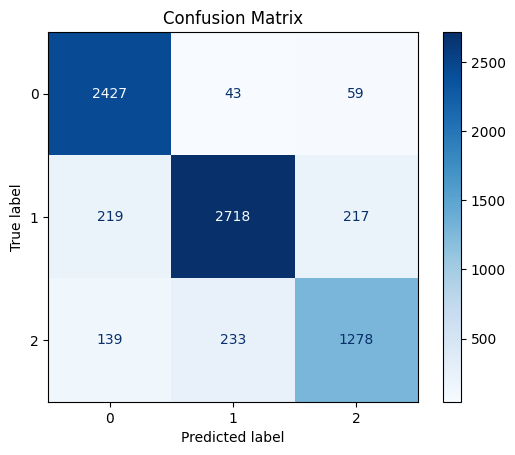

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [12]:
print("✅ Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))

✅ Accuracy on Test Set: 0.8759034501568254

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2529
           1       0.91      0.86      0.88      3154
           2       0.82      0.77      0.80      1650

    accuracy                           0.88      7333
   macro avg       0.87      0.87      0.87      7333
weighted avg       0.88      0.88      0.87      7333



In [13]:
import re
import string

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove numbers and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
def predict_unseen_comments(model, comments, vectorizer):
    # Step 1: Clean comments
    cleaned_comments = [clean_text(comment) for comment in comments]

    # Step 2: Vectorize using the fitted TF-IDF
    X_unseen = vectorizer.transform(cleaned_comments)

    # Step 3: Predict
    predictions = model.predict(X_unseen)

    return predictions


In [15]:
# Unseen raw comments
new_comments = [
    "What a terrible person you are!",
    "I absolutely loved this. Brilliant!",
    "Go to hell, you're a joke.",
    "Such a kind and helpful response, thank you!",
]

# Predict using cleaned and vectorized data
unseen_preds = predict_unseen_comments(final_model, new_comments, vectorizer)

# Print results
for comment, pred in zip(new_comments, unseen_preds):
    print(f"Comment: {comment}\n→ Predicted Category: {pred}\n")


Comment: What a terrible person you are!
→ Predicted Category: 2

Comment: I absolutely loved this. Brilliant!
→ Predicted Category: 1

Comment: Go to hell, you're a joke.
→ Predicted Category: 0

Comment: Such a kind and helpful response, thank you!
→ Predicted Category: 1

